In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold,train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [75]:
def load_data(filename,cols):
    dataset = pd.read_csv(filename,usecols=cols,encoding="latin1")
    dataset = dataset[cols]
    return dataset

In [76]:
def showResults(y_true, y_pred):
    print(classification_report(y_true,y_pred),'\n')
    cf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [77]:
dataset = load_data("cleaned_tweets.csv",['keyword','text','mean_word_length','char_count','target'])
dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True) 
dataset.tail()

,keyword,text,mean_word_length,char_count,target
7606,no_keyword,two giant crane holding bridge collapse nearby...,6.636364,83,1
7607,no_keyword,ahrary control wild fire california even north...,5.300000,125,1
7608,no_keyword,utc km volcano hawaii,7.250000,65,1
7609,no_keyword,police investigating e bike collided car littl...,6.263158,137,1
7610,no_keyword,latest home razed northern california wildfire...,6.307692,94,1


In [80]:
# Transforming tweets
text_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
vect_text = text_vectorizer.fit_transform(dataset['text'])
# Transforming keywords
keyword_vectorizer = TfidfVectorizer(ngram_range=(1,1))
vect_keyword = keyword_vectorizer.fit_transform(dataset['keyword'])
# Scaling meta features 
sc = StandardScaler()
meta_features = sc.fit_transform(dataset[['mean_word_length','char_count']])

Here we transform tweets, keywords and scale mean word length and character count seperately and stack all the three vectors horizontally

In [81]:
from scipy.sparse import hstack
X = hstack([vect_text, vect_keyword,meta_features])
y = dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state = 0)

# Decision Tree Classifier

In [82]:
DT_classifier = DecisionTreeClassifier()
DT_classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3008
           1       0.99      0.98      0.99      2319

    accuracy                           0.99      5327
   macro avg       0.99      0.99      0.99      5327
weighted avg       0.99      0.99      0.99      5327
 



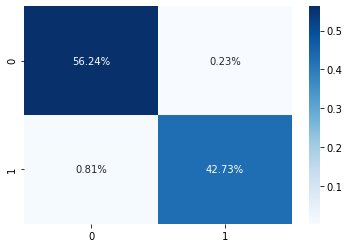

In [83]:
y_pred = DT_classifier.predict(X_train)
showResults(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1333
           1       0.67      0.65      0.66       951

    accuracy                           0.72      2284
   macro avg       0.71      0.71      0.71      2284
weighted avg       0.72      0.72      0.72      2284
 



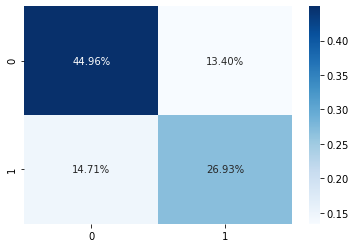

In [84]:
y_pred = DT_classifier.predict(X_test)
showResults(y_test, y_pred)

## GridSearch for Decision Tree Classifier

In [85]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 
grid_params = {'max_depth': range(60,85),
               'max_features': range(50,80)}

grid_DT_clf = GridSearchCV(DecisionTreeClassifier(), grid_params,
                         cv=skf, n_jobs=-1, verbose=True)

grid_DT_clf.fit(X_train, y_train)
print("Best Score: ", grid_DT_clf.best_score_)
print("Best Params: ", grid_DT_clf.best_params_)

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 692 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1692 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 3092 tasks      | elapsed:   50.6s


Best Score:  0.7428191915721973
Best Params:  {'max_depth': 84, 'max_features': 65}


[Parallel(n_jobs=-1)]: Done 3750 out of 3750 | elapsed:  1.0min finished


              precision    recall  f1-score   support

           0       0.87      1.00      0.93      3008
           1       0.99      0.81      0.89      2319

    accuracy                           0.92      5327
   macro avg       0.93      0.90      0.91      5327
weighted avg       0.92      0.92      0.91      5327
 



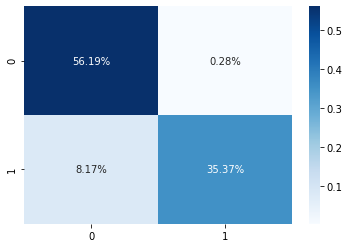

In [86]:
DT_classifier = grid_DT_clf.best_estimator_
y_pred = DT_classifier.predict(X_train)
showResults(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.73      0.84      0.78      1333
           1       0.72      0.56      0.63       951

    accuracy                           0.73      2284
   macro avg       0.72      0.70      0.71      2284
weighted avg       0.72      0.73      0.72      2284
 



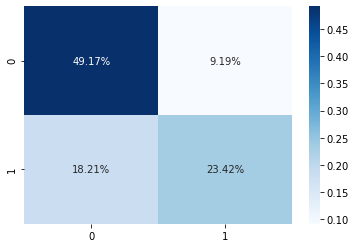

In [87]:
y_pred = DT_classifier.predict(X_test)
showResults(y_test, y_pred)

With the addition of new features Decision Tree's accuracy reduces from 76 to 73% also we can clearly see that with a training accuracy of 92% the model is overfitting and not able to generalize.

# Gaussian Naive Bayes

In [88]:
GNB_classifier = GaussianNB()
GNB_classifier.fit(X_train.toarray(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

              precision    recall  f1-score   support

           0       0.71      0.97      0.82      3008
           1       0.93      0.49      0.64      2319

    accuracy                           0.76      5327
   macro avg       0.82      0.73      0.73      5327
weighted avg       0.81      0.76      0.74      5327
 



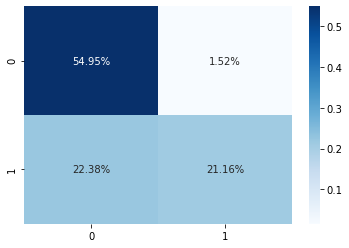

In [89]:
y_pred = GNB_classifier.predict(X_train.toarray())
showResults(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.71      0.95      0.82      1333
           1       0.87      0.47      0.61       951

    accuracy                           0.75      2284
   macro avg       0.79      0.71      0.71      2284
weighted avg       0.78      0.75      0.73      2284
 



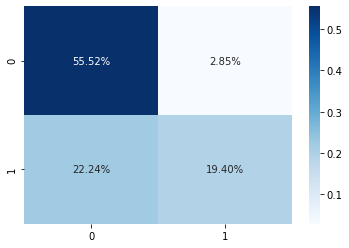

In [90]:
y_pred = GNB_classifier.predict(X_test.toarray())
showResults(y_test, y_pred)

With Gaussian Naive Bayes the accuracy has increased to 75.

# Logistic Regression

In [91]:
LR_classifier = LogisticRegression(max_iter=1000)
LR_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      3008
           1       0.86      0.76      0.81      2319

    accuracy                           0.84      5327
   macro avg       0.85      0.83      0.84      5327
weighted avg       0.84      0.84      0.84      5327
 



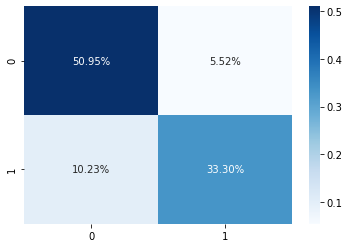

In [92]:
y_pred = LR_classifier.predict(X_train)
showResults(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1333
           1       0.78      0.71      0.74       951

    accuracy                           0.80      2284
   macro avg       0.79      0.78      0.79      2284
weighted avg       0.80      0.80      0.80      2284
 



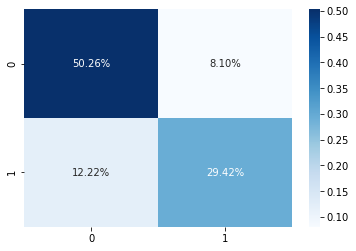

In [93]:
y_pred = LR_classifier.predict(X_test)
showResults(y_test, y_pred)

## GridSearch for Logistic Regression

In [94]:
grid_params = {
    'penalty' : ['l1', 'l2'],
    'C' : [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
    'solver' : ['liblinear'],
    'max_iter':[int(x) for x in np.linspace(100, 1000, num = 10)]
}
grid_LR_clf = GridSearchCV(estimator = LogisticRegression(), 
                           param_grid = grid_params,                           
                           verbose=True,
                           cv=skf,
                           n_jobs = -1)
grid_LR_clf.fit(X_train, y_train)
print("Best Score: ", grid_LR_clf.best_score_)
print("Best Params: ", grid_LR_clf.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.2s


Best Score:  0.7891858467880454
Best Params:  {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    9.3s finished


              precision    recall  f1-score   support

           0       0.83      0.90      0.87      3008
           1       0.86      0.76      0.81      2319

    accuracy                           0.84      5327
   macro avg       0.85      0.83      0.84      5327
weighted avg       0.84      0.84      0.84      5327
 



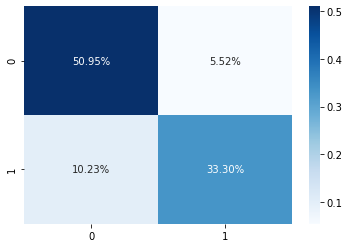

In [95]:
LR_classifier = grid_LR_clf.best_estimator_
y_pred = LR_classifier.predict(X_train)
showResults(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1333
           1       0.78      0.71      0.74       951

    accuracy                           0.80      2284
   macro avg       0.79      0.78      0.79      2284
weighted avg       0.80      0.80      0.80      2284
 



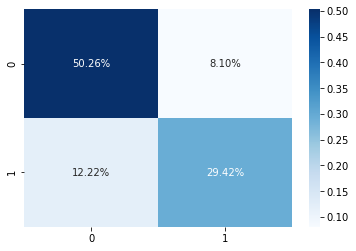

In [96]:
y_pred = LR_classifier.predict(X_test)
showResults(y_test, y_pred)

With Logistic Regression the results are much better with an accuracy of 80%

# Support Vector Classifier

In [97]:
SV_classifier = SVC() 
SV_classifier.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3008
           1       0.91      0.80      0.85      2319

    accuracy                           0.88      5327
   macro avg       0.88      0.87      0.87      5327
weighted avg       0.88      0.88      0.87      5327
 



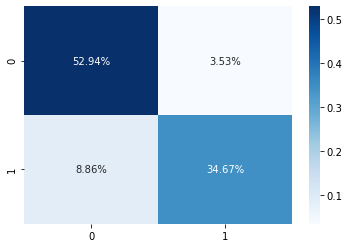

In [98]:
y_pred = SV_classifier.predict(X_train)
showResults(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1333
           1       0.78      0.67      0.72       951

    accuracy                           0.78      2284
   macro avg       0.78      0.77      0.77      2284
weighted avg       0.78      0.78      0.78      2284
 



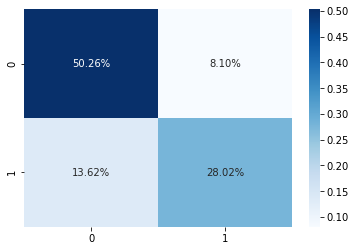

In [99]:
y_pred = SV_classifier.predict(X_test)
showResults(y_test, y_pred)

## GridSearch for Support Vector Classifier

In [100]:
grid_params = [{'C': [0.001, 0.01, 0.1, 1,3, 10, 100], 'kernel': ['linear']},
              {'C': [0.001, 0.01, 0.1, 1,3, 10, 100], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_SV_clf = GridSearchCV(estimator = SVC() ,
                           param_grid = grid_params,
                           verbose=True,
                           cv = skf,
                           n_jobs = -1)
grid_SV_clf.fit(X_train, y_train)
print("Best Score: ", grid_SV_clf.best_score_)
print("Best Params: ", grid_SV_clf.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.4min finished


Best Score:  0.7882502268142941
Best Params:  {'C': 1, 'kernel': 'linear'}


              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3008
           1       0.87      0.77      0.82      2319

    accuracy                           0.85      5327
   macro avg       0.86      0.84      0.85      5327
weighted avg       0.85      0.85      0.85      5327
 



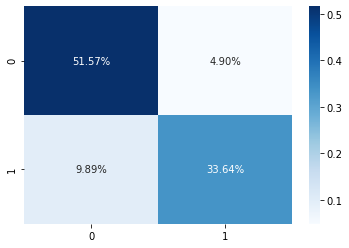

In [101]:
SV_classifier = grid_SV_clf.best_estimator_ 
y_pred = SV_classifier.predict(X_train)
showResults(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1333
           1       0.78      0.69      0.73       951

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284
 



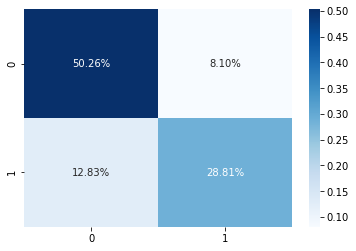

In [102]:
y_pred = SV_classifier.predict(X_test)
showResults(y_test, y_pred)

SVM classifier performs better than Gaussian Naive Bayes and Decision Trees but Logistic Regression is still the best clasifier so far

# Random Forest Classifier

In [103]:
RF_classifier = RandomForestClassifier()
RF_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3008
           1       0.99      0.98      0.99      2319

    accuracy                           0.99      5327
   macro avg       0.99      0.99      0.99      5327
weighted avg       0.99      0.99      0.99      5327
 



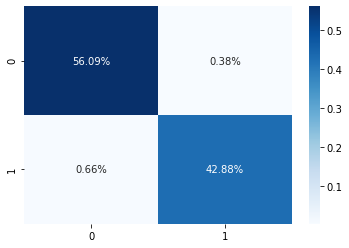

In [104]:
y_pred = RF_classifier.predict(X_train)
showResults(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1333
           1       0.80      0.65      0.72       951

    accuracy                           0.79      2284
   macro avg       0.79      0.77      0.77      2284
weighted avg       0.79      0.79      0.78      2284
 



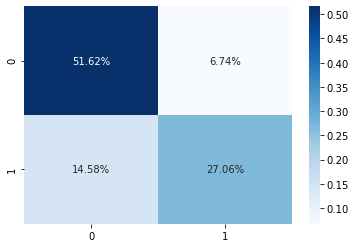

In [105]:
y_pred = RF_classifier.predict(X_test)
showResults(y_test, y_pred)

## RandomizedSearch for Random Forest Classifier

In [106]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000, num = 10)]
max_depth.append(None)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
              }
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = skf,n_jobs = -1,verbose=True)
rf_random.fit(X_train, y_train)
print("Best Score: ", rf_random.best_score_)
print("Best Params: ", rf_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 48.8min finished


Best Score:  0.7890017528560984
Best Params:  {'n_estimators': 780, 'max_depth': 120}


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3008
           1       0.99      0.93      0.96      2319

    accuracy                           0.97      5327
   macro avg       0.97      0.96      0.96      5327
weighted avg       0.97      0.97      0.97      5327
 



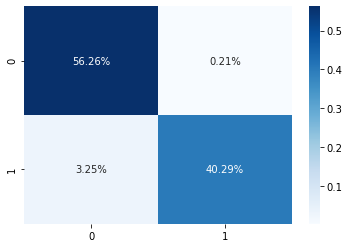

In [107]:
RF_classifier = rf_random.best_estimator_
y_pred = RF_classifier.predict(X_train)
showResults(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1333
           1       0.83      0.64      0.72       951

    accuracy                           0.79      2284
   macro avg       0.80      0.77      0.78      2284
weighted avg       0.80      0.79      0.79      2284
 



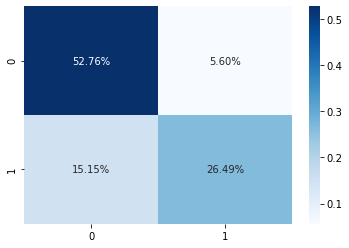

In [108]:
y_pred = RF_classifier.predict(X_test)
showResults(y_test, y_pred)

Similar to the Decision Tree we get a high training accuracy of 97%, but the model is not able to generalize and is overfitting with a validation accuracy of 79%.

## Multinomial Naive Bayes

In [109]:
X = hstack([vect_text, vect_keyword,dataset[['mean_word_length','char_count']]])
y = dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state = 0)

In [110]:
MNB_classifier = MultinomialNB(alpha=1)
MNB_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      3008
           1       0.81      0.75      0.78      2319

    accuracy                           0.81      5327
   macro avg       0.81      0.81      0.81      5327
weighted avg       0.81      0.81      0.81      5327
 



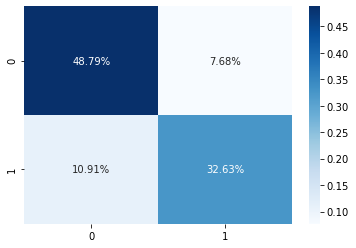

In [111]:
y_pred = MNB_classifier.predict(X_train)
showResults(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1333
           1       0.75      0.69      0.72       951

    accuracy                           0.78      2284
   macro avg       0.77      0.76      0.77      2284
weighted avg       0.78      0.78      0.78      2284
 



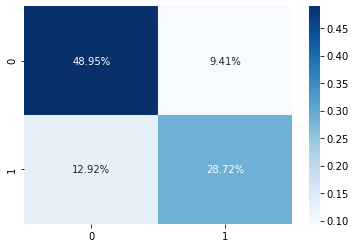

In [112]:
y_pred = MNB_classifier.predict(X_test)
showResults(y_test, y_pred)

In [113]:
grid_params = {
    'alpha': [0.0002, 0.0003, 0.0005,0.0001,0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
    'fit_prior': [True, False]
}
grid_MNB_clf = GridSearchCV(estimator = MultinomialNB(),
                            param_grid = grid_params,                           
                            verbose=True,
                            cv = skf,
                            n_jobs = -1)
grid_MNB_clf.fit(X_train, y_train)
print("Best Score: ", grid_MNB_clf.best_score_)
print("Best Params: ", grid_MNB_clf.best_params_)

Fitting 5 folds for each of 26 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.7858096169260718
Best Params:  {'alpha': 0.01, 'fit_prior': True}


[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    0.4s finished


              precision    recall  f1-score   support

           0       0.82      0.86      0.84      3008
           1       0.81      0.76      0.78      2319

    accuracy                           0.82      5327
   macro avg       0.82      0.81      0.81      5327
weighted avg       0.82      0.82      0.82      5327
 



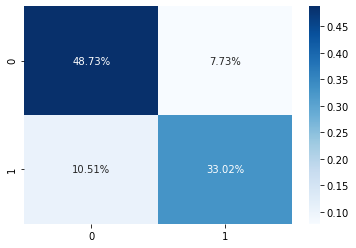

In [114]:
MNB_classifier = grid_MNB_clf.best_estimator_
y_pred = MNB_classifier.predict(X_train)
showResults(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1333
           1       0.75      0.70      0.73       951

    accuracy                           0.78      2284
   macro avg       0.78      0.77      0.77      2284
weighted avg       0.78      0.78      0.78      2284
 



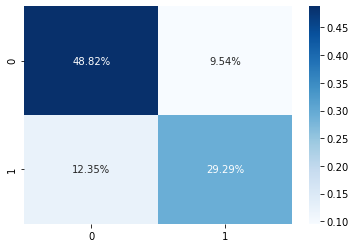

In [115]:
y_pred = MNB_classifier.predict(X_test)
showResults(y_test, y_pred)

As expected Multinomial Naive Bayes performs better than Gaussian Naive Bayes and gives an accuracy of 78%. 

# Logitic Regression with keywords and text

As per our analysis so far Logistic Regression with the inclusion of meta features and keywords gives the highest accuracy of 80%, but what if we exculde the meta features and focus on keywords and text . 

In [116]:
X = hstack([vect_text, vect_keyword])
y = dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state = 0)

In [117]:
LR_classifier = LogisticRegression(max_iter=1000)
LR_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      3008
           1       0.86      0.76      0.81      2319

    accuracy                           0.84      5327
   macro avg       0.84      0.83      0.84      5327
weighted avg       0.84      0.84      0.84      5327
 



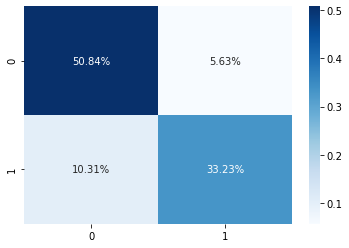

In [118]:
y_pred = LR_classifier.predict(X_train)
showResults(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1333
           1       0.78      0.69      0.73       951

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284
 



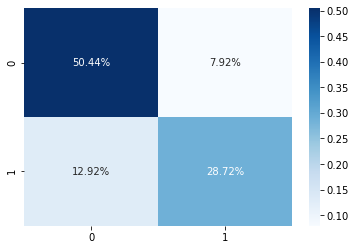

In [119]:
y_pred = LR_classifier.predict(X_test)
showResults(y_test, y_pred)

In [120]:
grid_params = {
    'penalty' : ['l1', 'l2'],
    'C' : [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
    'solver' : ['liblinear'],
    'max_iter':[int(x) for x in np.linspace(100, 1000, num = 10)]
}
grid_LR_clf = GridSearchCV(estimator = LogisticRegression(), 
                           param_grid = grid_params,                           
                           verbose=True,
                           cv=skf,
                           n_jobs = -1)
grid_LR_clf.fit(X_train, y_train)
print("Best Score: ", grid_LR_clf.best_score_)
print("Best Params: ", grid_LR_clf.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.1s


Best Score:  0.7920034528622643
Best Params:  {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    7.9s finished


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      3008
           1       0.86      0.76      0.81      2319

    accuracy                           0.84      5327
   macro avg       0.84      0.83      0.84      5327
weighted avg       0.84      0.84      0.84      5327
 



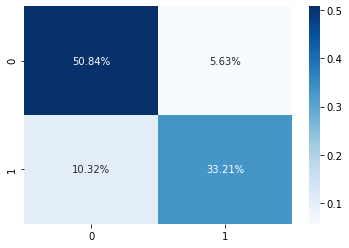

In [121]:
LR_classifier = grid_LR_clf.best_estimator_
y_pred = LR_classifier.predict(X_train)
showResults(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1333
           1       0.78      0.69      0.73       951

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284
 



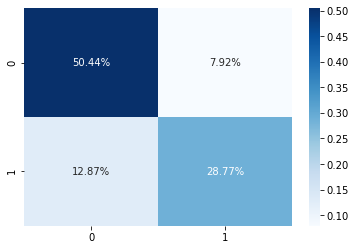

In [122]:
y_pred = LR_classifier.predict(X_test)
showResults(y_test, y_pred)

By excluding meta features we get an accuracy of 79% therefore the meta features derived during analysis have proved useful in increasing the accuracy of the classifier by 1%. 